## HW5

Necessary Packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


We set some hyperparameters and a random seed for precise comparisons.

In [2]:
seed=42
batch_size=64
num_epochs=40
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Load data and split into training and validation sets.







In [4]:
y_csv=[]
csv_data = csv.reader(open('y_train.csv','r'))
next(csv_data)
for line in csv_data:
    y_csv.append(int(line[1]))

x_train_sp = np.load('x_train_sp.npy').astype(np.float32)
x_train_wr = np.load('x_train_wr.npy').astype(np.float32)
x_train_wr.resize(x_train_wr.shape[0], 28, 28)
assert len(x_train_wr)==len(x_train_wr)
x_all=[]
for i in range(len(x_train_wr)):
    x_all.append([x_train_sp[i], x_train_wr[i]])

x_train, x_test, y_train, y_test = train_test_split(x_all, y_csv, test_size=0.2, random_state=seed)

Build class for the Dataset and Model.

In [5]:
class My_dataset(Dataset):
    def __init__(self,data, labels, transform=None):
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        each_data = self.data[idx]
        sp_data = torch.from_numpy(each_data[0]).float()
        img_data = self.transform(each_data[1]).float()
        each_label = self.label[idx]
        return sp_data, img_data, each_label

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(507,1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
        )

    def forward(self, x):
        return self.net(x)

class Conv_Net(nn.Module):
    def __init__(self, filter_size=3, dropout=False, activate='relu'):
        super(Conv_Net, self).__init__()

        pad_size = filter_size // 2
        self.conv1 = nn.Conv2d(1, 64, kernel_size=filter_size, stride=1, padding=pad_size)
        self.act1 = nn.ReLU() if activate == 'relu' else nn.Sigmoid()
        self.drop1 = nn.Dropout(p=0.5) if dropout else nn.Identity()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=filter_size, stride=1, padding=pad_size)
        self.act2 = nn.ReLU() if activate == 'relu' else nn.Sigmoid()
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)

        self.fc1 = nn.Linear(14 * 14 * 128, 256)
        # self.act3 = nn.ReLU() if activate == 'relu' else nn.Sigmoid()
        # self.drop2 = nn.Dropout(p=0.5) if dropout else nn.Identity()
        # self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x
class ALL(nn.Module):
    def __init__(self):
        super().__init__()
        self.audio = Net()
        self.img = Conv_Net(filter_size=5, dropout=False, activate='relu')
        self.weight_audio = nn.Linear(256, 1)
        self.weight_img = nn.Linear(256, 1)
        self.out = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, audio, img):
        audio = self.audio(audio)
        img = self.img(img)
        weight_audio = torch.sigmoid(self.weight_audio(audio))
        weight_img = torch.sigmoid(self.weight_img(img))
        x = weight_audio * audio + weight_img * img
        return self.out(x), audio, img




In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])
train_dataset = My_dataset(x_train, y_train, transform=transform)
val_dataset = My_dataset(x_test,y_test, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                                    pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False,
                                    pin_memory=True)
my_model = ALL()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model.to(device)
optimizer = torch.optim.SGD(my_model.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

Train model.

In [7]:
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for i, (sp, images, labels) in enumerate(tqdm(train_dataloader)):
        sp = sp.to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs, audio_feature, img_feature = my_model(sp, images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        total = 0
        y_pred =[]
        for sp, images, labels in tqdm(val_dataloader):
            sp = sp.to(device)
            images = images.to(device)
            labels = labels.to(device)
            outputs, audio_feature, img_feature = my_model(sp, images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred+=predicted.cpu().numpy().tolist()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'The classification accuracy of the network on the {total} test images is {100 * correct / total} %')
    macro_f1=f1_score(y_test, y_pred, average='macro')
    print(f'F1_score: {macro_f1}')
    scheduler.step()

epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.26it/s]


The classification accuracy of the network on the 12000 test images is 96.925 %
F1_score: 0.9691564540689057
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.25it/s]


The classification accuracy of the network on the 12000 test images is 97.55833333333334 %
F1_score: 0.9757361081896206
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.10it/s]


The classification accuracy of the network on the 12000 test images is 97.21666666666667 %
F1_score: 0.9721097281946459
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 163.53it/s]


The classification accuracy of the network on the 12000 test images is 98.45 %
F1_score: 0.9845100470680723
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.83it/s]


The classification accuracy of the network on the 12000 test images is 98.4 %
F1_score: 0.9840267987803504
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 159.58it/s]


The classification accuracy of the network on the 12000 test images is 98.73333333333333 %
F1_score: 0.9873001287266744
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.05it/s]


The classification accuracy of the network on the 12000 test images is 98.58333333333333 %
F1_score: 0.9857792030845749
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.32it/s]


The classification accuracy of the network on the 12000 test images is 98.875 %
F1_score: 0.9886745947568766
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.74it/s]


The classification accuracy of the network on the 12000 test images is 98.73333333333333 %
F1_score: 0.9873051854247787
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.39it/s]


The classification accuracy of the network on the 12000 test images is 98.6 %
F1_score: 0.9858977600051354
epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.32it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899131133569803
epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 163.46it/s]


The classification accuracy of the network on the 12000 test images is 99.03333333333333 %
F1_score: 0.9903335649881498
epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 156.92it/s]


The classification accuracy of the network on the 12000 test images is 99.03333333333333 %
F1_score: 0.990356175151855
epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 159.98it/s]


The classification accuracy of the network on the 12000 test images is 99.05 %
F1_score: 0.9905164345759572
epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 150.88it/s]


The classification accuracy of the network on the 12000 test images is 99.01666666666667 %
F1_score: 0.9901776776314793
epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.82it/s]


The classification accuracy of the network on the 12000 test images is 99.025 %
F1_score: 0.9902620271768118
epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.18it/s]


The classification accuracy of the network on the 12000 test images is 99.00833333333334 %
F1_score: 0.9900876246766448
epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.69it/s]


The classification accuracy of the network on the 12000 test images is 99.00833333333334 %
F1_score: 0.9900842648369009
epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 157.31it/s]


The classification accuracy of the network on the 12000 test images is 99.0 %
F1_score: 0.9900034761578572
epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.53it/s]


The classification accuracy of the network on the 12000 test images is 99.0 %
F1_score: 0.9900128610127087
epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 163.31it/s]


The classification accuracy of the network on the 12000 test images is 99.01666666666667 %
F1_score: 0.9901795190511115
epoch 21


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 157.51it/s]


The classification accuracy of the network on the 12000 test images is 99.0 %
F1_score: 0.9900087220144007
epoch 22


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 162.75it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 23


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.25it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 24


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 161.49it/s]


The classification accuracy of the network on the 12000 test images is 99.0 %
F1_score: 0.9900158269264961
epoch 25


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 166.12it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 26


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.32it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 27


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.89it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 28


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.67it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 29


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.24it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 30


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 165.69it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 31


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.74it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 32


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 167.38it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 33


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.17it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 34


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 167.30it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 35


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.87it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 36


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 161.56it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 37


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 166.05it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 38


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 167.08it/s]


The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062
epoch 39


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 160.67it/s]

The classification accuracy of the network on the 12000 test images is 98.99166666666666 %
F1_score: 0.9899256134783062


Test model and write the test results.

In [8]:
my_model.eval()
x_test_sp = np.load('x_test_sp.npy').astype(np.float32)
x_test_wr = np.load('x_test_wr.npy').astype(np.float32)
x_test_wr.resize(x_test_wr.shape[0], 28, 28)
f = open("Preds.csv",'w',encoding='UTF-8', newline='')
writer = csv.writer(f)

writer.writerow(["row_id", "label"])
for i in tqdm(range(len(x_test_sp))):
    each_sp = torch.from_numpy(x_test_sp[i]).unsqueeze(0).to(device)
    each_img = transform(x_test_wr[i]).unsqueeze(0).to(device)
    with torch.no_grad():
        result, audio_feature, img_feature = my_model(each_sp, each_img)
    _, pred = torch.max(result.data, 1)
    writer.writerow([str(i), str(pred.item())])
f.close()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.81it/s]


Feature Extraction and Dimensionality Reduction with t-SNE.

In [12]:
audio_tsne=torch.randn(1,256)
img_tsne=torch.randn(1,256)
label_tsne = []
with torch.no_grad():
    for sp, images, labels in tqdm(val_dataloader):
        sp = sp.to(device)
        images = images.to(device)
        outputs, audio_feature, img_feature = my_model(sp, images)
        label_tsne += labels.cpu().numpy().tolist()
        audio_tsne = torch.cat((audio_tsne, audio_feature.cpu().detach()))
        img_tsne = torch.cat((img_tsne, img_feature.cpu().detach()))

audio_tsne = audio_tsne[1:].numpy()
img_tsne = img_tsne[1:].numpy()
label_name=['0','1','2','3','4','5','6','7','8','9']
import seaborn as sns
n_class = len(label_name) 
palette = sns.hls_palette(n_class) 
# sns.palplot(palette)
# print(palette)
from sklearn.manifold import TSNE
feature2D=[]
tsne = TSNE(n_components=2, n_iter=1000, perplexity=30)
audio_tsne_2d = tsne.fit_transform(audio_tsne)
feature2D.append(audio_tsne_2d)
tsne = TSNE(n_components=2, n_iter=1000, perplexity=30)
img_tsne_2d = tsne.fit_transform(img_tsne)
feature2D.append(img_tsne_2d)
name = ['Audio', 'Img']

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 94.08it/s]


Draw the picture.

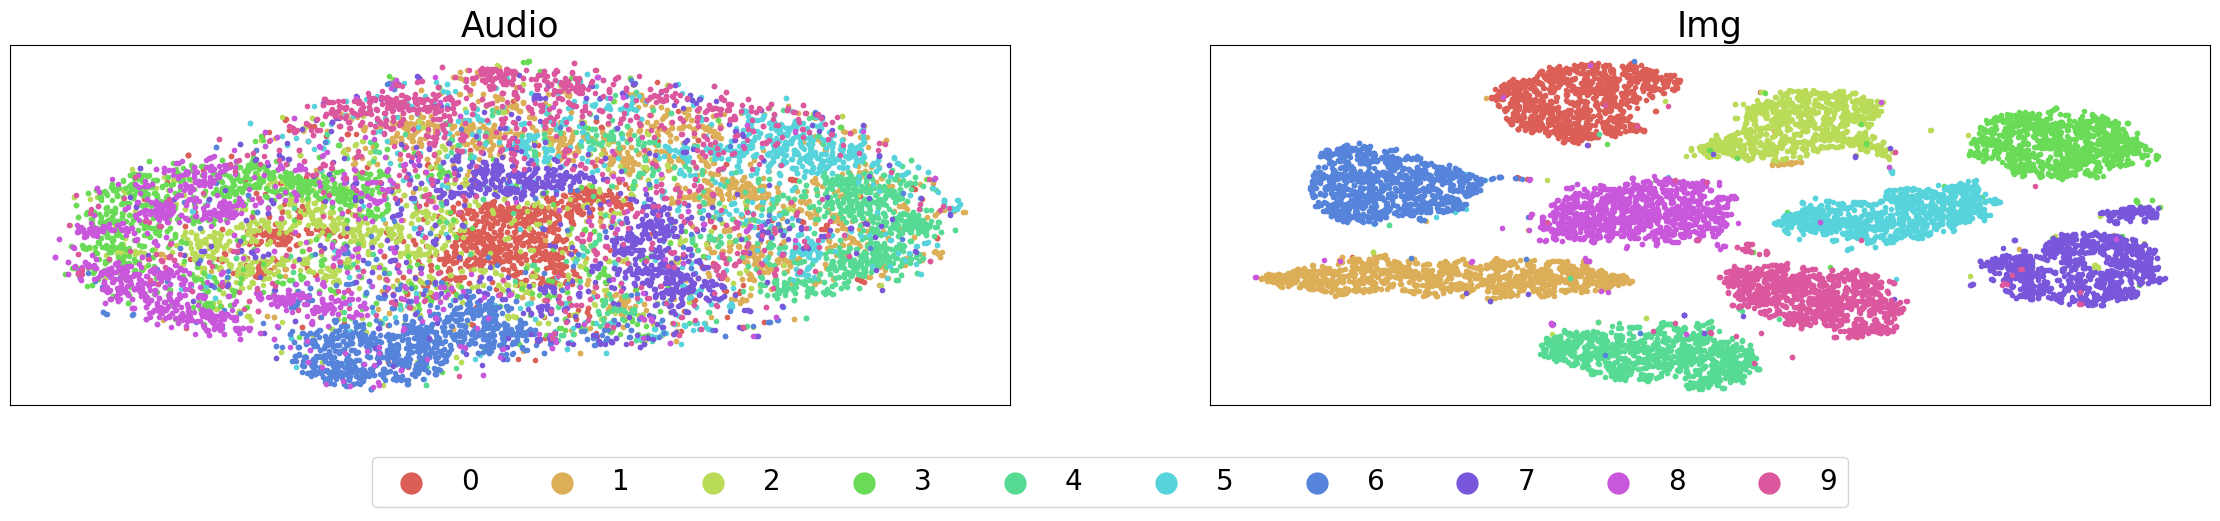

In [13]:
fig = plt.figure(figsize=(22,6))
np_label=np.array(label_tsne)
for i in range(1,3):
    ax = fig.add_subplot(1,2,i)
    ax.set_title(name[i-1],fontsize=25)
    X_tsne_2d=feature2D[i-1]
    type_label=[]
    for k in range(len(label_name)):
        indexnumber=np.where(np_label==k)
        color = palette[k]
        typek=ax.scatter(X_tsne_2d[indexnumber, 0], X_tsne_2d[indexnumber, 1], color=color, marker='.')
        type_label.append(typek)
        plt.xticks([])
        plt.yticks([])
plt.subplots_adjust(left=0,right=1,top=0.8,bottom=0.2)
fig.legend(label_name, ncol=10,loc = 'lower center',markerscale=5, fontsize=20)
plt.savefig('tsne.pdf', dpi=300, format='pdf') 
plt.show()